In [104]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import sqrt
from scipy import stats
from pandas import Series, DataFrame, read_html

import urllib, json
from urllib.request import urlopen
from random import gauss, seed, randint
from datetime import datetime as dt
from pandas import Series, DataFrame, read_html
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Import and reshape Data

In [105]:
Oil_Price = pd.read_csv('BrentPrice.csv')
#source = IEA
Oil_Price.head()

,Day,Dollars per Barrel
0,06/7/2021,70.89
1,06/4/2021,71.30
2,06/3/2021,70.71
3,06/2/2021,70.60
4,06/1/2021,70.03


<AxesSubplot:>

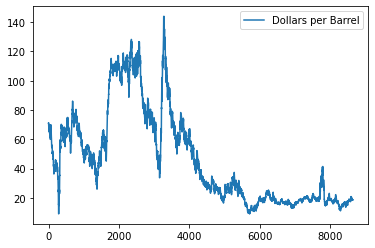

In [106]:
Oil_Price.plot()

In [107]:
Data = pd.read_excel('Production_Oil.xlsx')
# source = http://developpement-durable.bsocom.fr/Statistiques/TableViewer/tableView.aspx?ReportId=13137
Data.tail()

,Période,1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt),1.1 Production de pétrole brut (en kt),1.2 Production d'hydrocarbures extraits du gaz naturel (en kt),2. Solde importateur (importations - exportations) tous produits pétroliers (en kt),2.1 Importations totales de produits pétroliers (en kt),2.1.1 Importations de pétrole brut et condensats (en kt),2.1.2 Importations d'autres produits à distiller (APD) (en kt),2.1.3 Importations de produits pétroliers raffinés (en kt),2.2 Exportations de produits pétroliers raffinés (en kt),...,5.5 Ventes de gazole non routier (en kt),5.5 Ventes de carburéacteur (en kt),5.6 Ventes de gaz de pétrole liquéfiés (GPL) (en kt),5.7 Ventes de produits à usage non énergétique (en kt),"6. Consommation primaire de produits pétroliers, hors autoconsommation des raffineries corrigée du climat (en kt)",6.1 Ventes totales de fioul lourd (FOL) corrigées du climat (en kt),6.1.1 Ventes de fioul lourd (FOL) à l'industrie corrigées du climat (en kt),6.2 Ventes de fioul domestique (FOD) corrigées du climat (en kt),6.3 Ventes de gaz de pétrole liquéfiés (GPL) corrigées du climat (en kt),7. Indice de rigueur climatique pour la France métropolitaine (ref.1 pour la période 1986-2015) (sans unité)
479,2020-12-01,56.585,56.585,0.0,4299.74106,5376.478415,1855.93,0,3520.548415,1076.737355,...,260.5,266.50,184.4,877.741332,5327.33832,16.021517,10.721517,818.0032304,184.6715374,0.901712
480,2021-01-01,57.910,57.910,0.0,6170.773344,6922.30854,2385.018,0,4537.29054,751.535196,...,237.4,286.40,190.7,818.948507,5277.945175,14.161065,8.861065,985.2007092,199.4631719,1.039198
481,2021-02-01,51.677,51.677,0.0,5116.243625,5983.624098,2214.629,0,3768.995098,867.3804730000001,...,268.1,234.60,177.9,818.052405,5059.400725,13.905108,10.905108,941.2148404,183.222323,0.815429
482,2021-03-01,56.551,56.551,0.0,5111.278003,6158.494351,2770.378,0,3388.116351,1047.216348,...,403.2,165.10,170.1,826.680945,5458.451535,14.428259,9.128259,870.7418326,162.3444847,1.019648
483,2021-04-01,55.392,55.392,0.0,-,-,-,-,-,-,...,400.3505,233.52,138.0,722.907857,4876.677219,13.576706,8.276706,759.8675958,135.9807868,1.278883


In [108]:
# we keep only the date, the petrol consumption and the petrol production

Oil_Data = Data[['Période','1.1 Production de pétrole brut (en kt)','4. Consommation totale de produits pétroliers, hors autoconsommation des raffineries  (en kt)']]
Oil_Data = Oil_Data.rename(columns={'Période':'Date'})
Oil_Data = Oil_Data.rename(columns={'1.1 Production de pétrole brut (en kt)':'Production'})
Oil_Data = Oil_Data.rename(columns={'4. Consommation totale de produits pétroliers, hors autoconsommation des raffineries  (en kt)':'Consommation'})
Oil_Data.DATE = pd.to_datetime(Oil_Data.Date, format='%Y%m%d')
Oil_Data.head()

<ipython-input-108-b2b79f65b8e4>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Oil_Data.DATE = pd.to_datetime(Oil_Data.Date, format='%Y%m%d')


,Date,Production,Consommation
0,1981-01-01,134.5,9781.2
1,1981-02-01,125.6,8336.4
2,1981-03-01,144.2,7602.1
3,1981-04-01,139.4,6159.7
4,1981-05-01,140.0,7088.5


In [110]:
Oil_Price = Oil_Price.rename(columns={'Day':'Date'})
Oil_Price['Date'] = pd.to_datetime(Oil_Price['Date'], infer_datetime_format=True)
Oil_Price.Date = pd.to_datetime(Oil_Price.Date, format='%Y%m%d')
Oil_Price.head()

,Date,Dollars per Barrel
0,2021-06-07,70.89
1,2021-06-04,71.30
2,2021-06-03,70.71
3,2021-06-02,70.60
4,2021-06-01,70.03


In [111]:
# considering that the Oil_Data file is on a mensual basis (compute every 1st of each month), 
# we use here a trick to keep only the 1st of each month for the Oil_Price Data

Oil_Price['Day'] = Oil_Price['Date'].dt.strftime('%d')
Oil_Price = Oil_Price[Oil_Price.Day.eq('01')]
Oil_Price.head()

,Date,Dollars per Barrel,Day
4,2021-06-01,70.03,01
45,2021-04-01,63.85,01
68,2021-03-01,64.56,01
88,2021-02-01,56.42,01
130,2020-12-01,47.03,01


In [90]:
Oil_Price.drop(columns=['Day'])
Oil_Price = Oil_Price.set_index('Date')
Oil_Price

,Dollars per Barrel,Day
Date,,
2021-06-01,70.03,01
2021-04-01,63.85,01
2021-03-01,64.56,01
2021-02-01,56.42,01
2020-12-01,47.03,01
...,...,...
1987-12-01,17.65,01
1987-10-01,18.50,01
1987-09-01,18.43,01


In [91]:
# we merge all our Data into a single Data Frame

DF = Oil_Data
DF = DF.merge(Oil_Price[['Dollars per Barrel']], how='inner', left_on='Date' ,right_on='Date')
DF = DF.rename(columns={'Dollars per Barrel':'Price'})
DF

,Date,Production,Consommation,Price
0,1987-06-01,266.000,6092.600000,18.65
1,1987-07-01,283.000,6462.000000,18.98
2,1987-09-01,268.000,5963.500000,18.43
3,1987-10-01,269.000,6638.600000,18.50
4,1987-12-01,300.000,7695.600000,17.65
...,...,...,...,...
254,2020-10-01,48.500,5787.509457,39.75
255,2020-12-01,56.585,5388.641332,47.03
256,2021-02-01,51.677,4945.952405,56.42
257,2021-03-01,56.551,5604.380945,64.56


# Data Correlation

<AxesSubplot:>

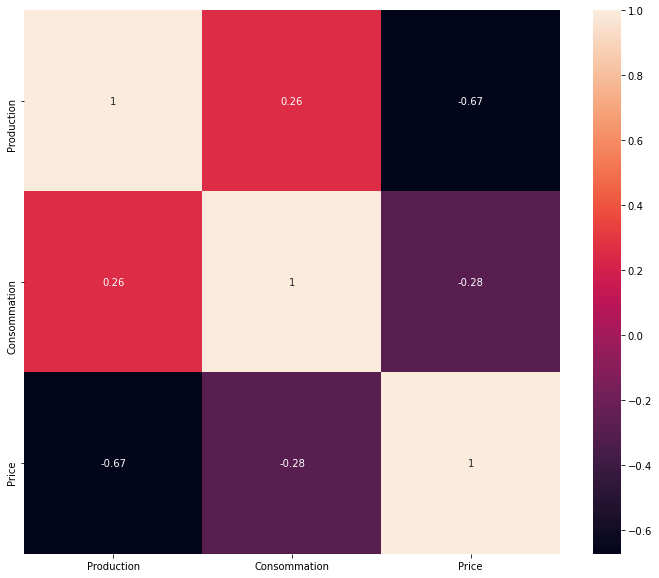

In [92]:
plt.figure(figsize=(12,10))
sns.heatmap(DF.corr(), annot=True)

# Model Creation

In [93]:
def regression_linéaire (x_train, x_test, y_train, y_test):
    regression_model = LinearRegression()
    regression_model.fit(x_train, y_train)
    y_train_predicted  = regression_model.predict(x_train)
    RMSE = (np.sqrt(mean_squared_error(y_train, y_train_predicted)))
    R2 = r2_score(y_train, y_train_predicted)

    print('Slope:' , regression_model.coef_)
    print('Intercept:' , regression_model.intercept_)
    print('Le RMSE pour le modèle apprentissage est {}'.format(RMSE))
    print('Le score R2 pour le modèle apprentissage est {}'.format(R2))
    print('\n')
    
    y_test_predicted = regression_model.predict(x_test)
    RMSE = (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
    R2 = r2_score(y_test, y_test_predicted)
    print('Le RMSE pour le modèle test est {}'.format(RMSE))
    print('Le score R2 pour le modèle test est{}'.format(R2))
    print('\n')
    
    plt.scatter(x_train, y_train, s=10)
    plt.xlabel('x')
    plt.ylabel('y')
    
    
    plt.plot(x_train, y_train_predicted, color='r')
    plt.show()

In [114]:
DF.set_index('Date', inplace=True, drop=False)
DF

,Date,Production,Consommation,Price
Date,,,,
1987-06-01,1987-06-01,266.000,6092.600000,18.65
1987-07-01,1987-07-01,283.000,6462.000000,18.98
1987-09-01,1987-09-01,268.000,5963.500000,18.43
1987-10-01,1987-10-01,269.000,6638.600000,18.50
1987-12-01,1987-12-01,300.000,7695.600000,17.65
...,...,...,...,...
2020-10-01,2020-10-01,48.500,5787.509457,39.75
2020-12-01,2020-12-01,56.585,5388.641332,47.03
2021-02-01,2021-02-01,51.677,4945.952405,56.42


# Data set split between test and test

In [146]:
#There is different way to split a Data set, here I choose to split it about a the Date, it correspond to 85%/15% split

split_date = pd.datetime(2017, 1, 1)

DF_train = DF.loc[DF.index < split_date]
DF_test = DF.loc[DF.index >= split_date]

<ipython-input-146-2a34e524bef5>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2017, 1, 1)


In [147]:
DF_train.head()

,Date,Production,Consommation,Price
Date,,,,
1987-06-01,1987-06-01,266.0,6092.6,18.65
1987-07-01,1987-07-01,283.0,6462.0,18.98
1987-09-01,1987-09-01,268.0,5963.5,18.43
1987-10-01,1987-10-01,269.0,6638.6,18.50
1987-12-01,1987-12-01,300.0,7695.6,17.65


# Predict Oil Price with Oil consumption

Slope: [[-0.02046132]]
Intercept: [186.31462673]
Le RMSE pour le modèle apprentissage est 31.724735996128718
Le score R2 pour le modèle apprentissage est 0.11157323259009821


Le RMSE pour le modèle test est 27.605457254782394
Le score R2 pour le modèle test est-2.4967495298298643




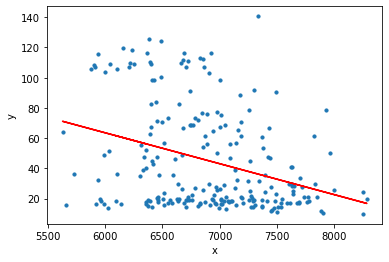

In [148]:
x_train = DF_train[['Consommation']]
x_test = DF_test[['Consommation']]
y_train = DF_train[['Price']]
y_test = DF_test[['Price']]
BTC_DPI = regression_linéaire(x_train, x_test, y_train, y_test)

# Predict Oil Price with Oil Prodution

Slope: [[-0.31362722]]
Intercept: [89.10803664]
Le RMSE pour le modèle apprentissage est 24.343463866033723
Le score R2 pour le modèle apprentissage est 0.47689321773294624


Le RMSE pour le modèle test est 20.778925909384434
Le score R2 pour le modèle test est-0.9811658071818039




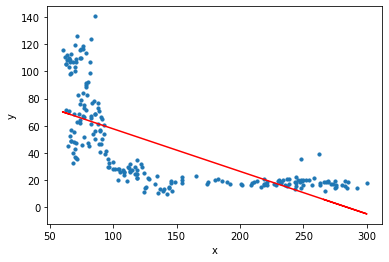

In [152]:
x_train = DF_train[['Production']]
x_test = DF_test[['Production']]
y_train = DF_train[['Price']]
y_test = DF_test[['Price']]
BTC_DPI = regression_linéaire(x_train, x_test, y_train, y_test)

# Conclusion